In [8]:
import os
import numpy as np
import random
import math
import pandas as pd
import time
import matplotlib.pyplot as plt

In [9]:
%matplotlib widget

In [10]:
plt.style.use("bmh")

# -- set grayscale to be the default color map 
# plt.rcParams["image.cmap"] = "gist_gray"
plt.rcParams["axes.grid"] = False
plt.rcParams["figure.figsize"] = (15, 8)
plt.rcParams['axes.titlepad'] = 0 

In [11]:
def create_source_locations(bimg, seed):
    """
    Create locations for sources
    """

    # -- seed the random number generators
    np.random.seed(seed)
    
    # -- get the code for each building 
    bcodes = np.unique(bimg)

    # -- initialize location lists/arrays
    location = []
    
    # -- since code == 0 represents the background, we start from 1
    for i, bcode in enumerate(bcodes):

        # -- ignore background
        if bcode == 0:
            continue
        
        # -- alert the user
        if (i + 1) % 100 == 0:
            print("working on {0} of {1}\r".format(i + 1, len(bcodes)), end="")
        
        # -- get pixels' location for each building (ind[0] is the row value and ind[1] is the col value)
        ind = np.where(bimg == bcode)
    
        # -- get locations for selected sources
        loc = np.array(ind).T
    
        # -- shuffle it
        np.random.shuffle(loc)
    
        # -- select sources for every 100 pixels
        pix_loc = loc[::100]
    
        location.append(np.array(pix_loc)) 
    
    return np.concatenate(location)

In [12]:
def create_timeseries(nsrc, ntimesteps, seed):
    """
    Create simulated time series.
    """
    
    # -- seed the random number generators
    np.random.seed(seed)

    # -- initialize time series lists/arrays
    srcs = []
    src_tmp = np.zeros(ntimesteps)
        
    # -- add brightness for each source
    for j in range(nsrc):

        # -- alert the user
        if (j + 1) % 100 == 0:
            print("working on {0} of {1}\r".format(j + 1, nsrc), end="")
        
        # -- we assume that each source will turn on and off no more than 10 times a night
        # -- generate a random number for lights on
        n_ons = np.random.randint(1, 10)
 
        # -- add brightness for each "on" period
        for jj in range(0, n_ons):
            
            # -- pick a random start point (0-1800), which is 9pm to 2am
            st = np.random.randint(0, 1800)
            
            # -- the length of turning on the lights is between 10 mins to 1hours
            en = st + np.random.randint(60, 360)
                        
            # -- generate random brightness value to my list
            on_lum = round(np.random.uniform(0.1, 1.0), 2)

            # -- add this to the source
            src_tmp[st:en] += on_lum
            
        # -- append to source list
        srcs.append(src_tmp.copy())
            
        # -- re-zero source
        src_tmp[:] = 0.0
    
    return np.array(srcs)

In [13]:
# -- load buildingID image
bimg = np.load("../../Downloads/bbls_test.npy").astype(int)

In [14]:
# -- set the seeds for the locations and time series (up to 6 digits)
seed_loc = 314
seed_ts = 964

# -- set number of time steps (9 hours assuming 10 seconds / image )
ntsteps = 6 * 60 * 9

# -- get the locations
loc_fname = "../../lighting-tech-changeover/output/img_simu_loc_{0:06}.npy".format(seed_loc)

if os.path.isfile(loc_fname):
    loc = np.load(loc_fname)
else:
    print(loc_fname + " not found... creating source locations")
    loc = create_source_locations(bimg, seed_loc)
    np.save(loc_fname, loc)

# -- get the corresponding time series
ts_fname = "../../lighting-tech-changeover/output/img_simu_src_curve_{0:06}.npy".format(seed_ts)

if os.path.isfile(ts_fname):
    srcs = np.load(ts_fname)
else:
    print(ts_fname + " not found... creating source times series")
    srcs = create_timeseries(len(loc), ntsteps, seed_ts)
    np.save(ts_fname, srcs)

../../lighting-tech-changeover/output/img_simu_src_curve_000964.npy not found... creating source times series


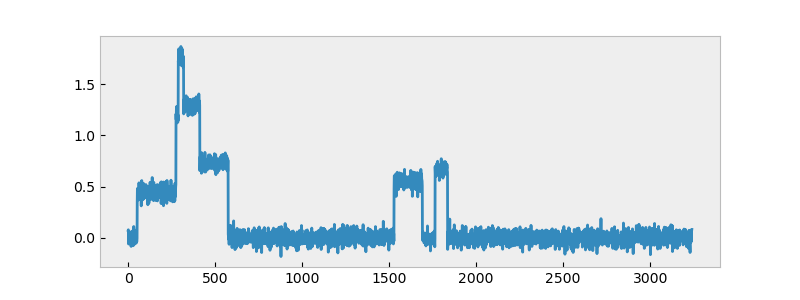

In [15]:
plt.close("all")
plt.figure(figsize=(8, 3))
plt.plot(srcs[20] + 0.05 * np.random.randn(srcs.shape[1]))

In [16]:
# -- generate light curve with noise

# -- duplicate each light curve by five times
src = np.repeat(srcs, repeats=5, axis=0)

# -- get full list of source location
loc_new = []
for i in range(len(loc)):
    loc0 = (loc[i][0] + 1, loc[i][1])
    loc1 = (loc[i][0] - 1, loc[i][1])
    loc2 = (loc[i][0], loc[i][1])
    loc3 = (loc[i][0], loc[i][1] + 1)
    loc4 = (loc[i][0], loc[i][1] - 1)
    
    
    loc_new.append(loc0)
    loc_new.append(loc1)
    loc_new.append(loc2)
    loc_new.append(loc3)
    loc_new.append(loc4)

# -- add sources curve to time series images
imgs = np.zeros((2560, 1920, 3240))
for i in range(len(loc)):
    imgs[loc[i][0], loc[i][1], :] = src[i]

# -- bin our image by 80 and get the time series image for a given night
fac = 80
sh = imgs.shape
img_bin = imgs.reshape(sh[0]//fac, fac, sh[1]//fac, fac, sh[2]).mean(axis=(1, 3))


# -- add gaussian noise
mean = 0.0
sigma = 0.01
new_amp = sigma/ math.sqrt(6400)
np.random.seed(333)
gaussian = np.random.normal(mean, new_amp, (img_bin.shape[0], img_bin.shape[1])) 

In [18]:
# -- add noise to binned image
img_bin_noise = img_bin.copy()
for i in range(3240):
    img_bin_noise[:, :, i] = img_bin[:, :, i] + gaussian

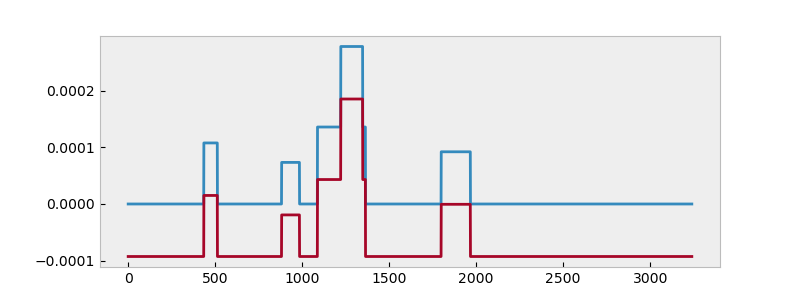

In [19]:
plt.figure(figsize=(8, 3))
plt.plot(img_bin[13, 10, :])
plt.plot(img_bin_noise[13, 10, :])

In [81]:
# -- turn off all light sources in one building and check its light curve
# -- check the building ID
ID = np.unique(bimg[1340:1500, 720:880])
ID

array([         0, 1008337502, 1008350041, 1008460030, 1008460033,
       1008470027, 1008470029, 1008470033, 1008470040, 1008470050,
       1008480023, 1008480028, 1008480043, 1008487501, 1008487503,
       1008487505, 1008490030, 1008490031, 1008490048, 1008497501,
       1008497504, 1008497508, 1008507501, 1008510060, 1008517502,
       1008517504, 1008517505, 1008530001, 1008530002, 1008560009,
       1008560011, 1008567502, 1008570075, 1008570076, 1008577502,
       1008580003, 1008580078, 1008707501, 1008710003, 1008730001,
       1008730004, 1008730067])

In [82]:
'lets turn off the first building'

'lets turn off the first building'

In [83]:
# -- let's turn off the first building
# -- get the source locations
ind = np.where(bimg == ID[1])
buid_loc = np.array([ind[0],ind[1]]).T
buid_loc[:, 0]

array([1377, 1377, 1377, ..., 1666, 1667, 1667])

In [84]:
# -- select the builing and turn off this building from 10 to 11 pm
for i in range(len(buid_loc)):
    imgs[buid_loc[i][0], buid_loc[i][1], 360:720] = 0
    
# -- bin our image by 80 and get the time series image for a given night
fac = 80
sh = imgs.shape
img_bin_off = imgs.reshape(sh[0]//fac, fac, sh[1]//fac, fac, sh[2]).mean(axis=(1, 3))

# -- add noise to binned image
for i in range(3240):
    img_bin_off[:, :, i] = img_bin_off[:, :, i] + gaussian

In [85]:
# -- check the area of this building
print("binned row min", round(buid_loc[:, 0].min()/80))
print("binned row max", round(buid_loc[:, 0].max()/80))
print("binned col min", round(buid_loc[:, 1].min()/80))
print("binned col max", round(buid_loc[:, 1].max()/80))

binned row min 17
binned row max 21
binned col min 10
binned col max 11


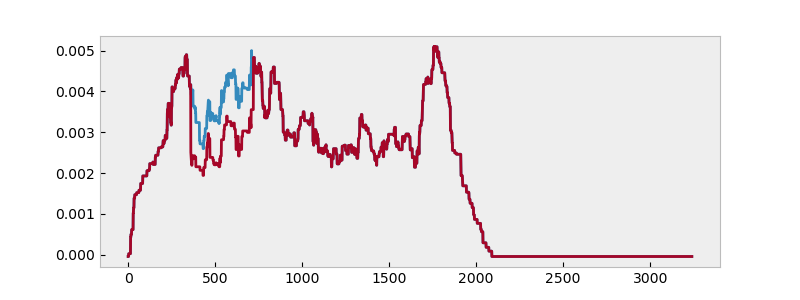

In [86]:
plt.figure(figsize=(8, 3))
plt.plot(img_bin_noise[17, 10, :])
plt.plot(img_bin_off[17, 10, :])

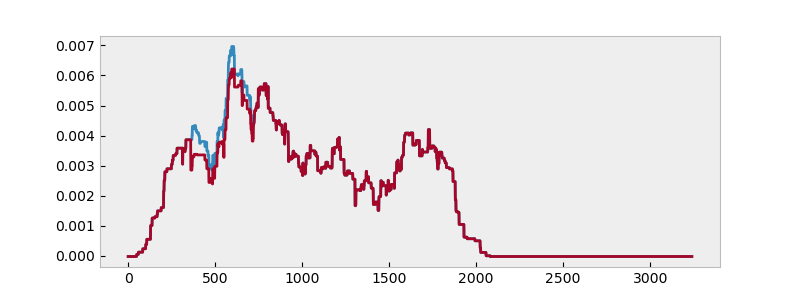

In [87]:
plt.figure(figsize=(8, 3))
plt.plot(img_bin_noise[17, 11, :])
plt.plot(img_bin_off[17, 11, :])

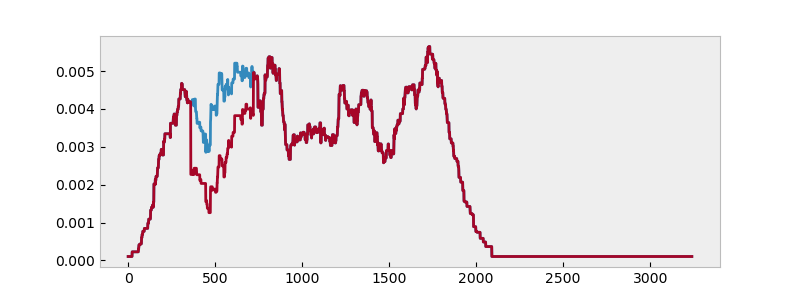

In [88]:
plt.figure(figsize=(8, 3))
plt.plot(img_bin_noise[18, 11, :])
plt.plot(img_bin_off[18, 11, :])

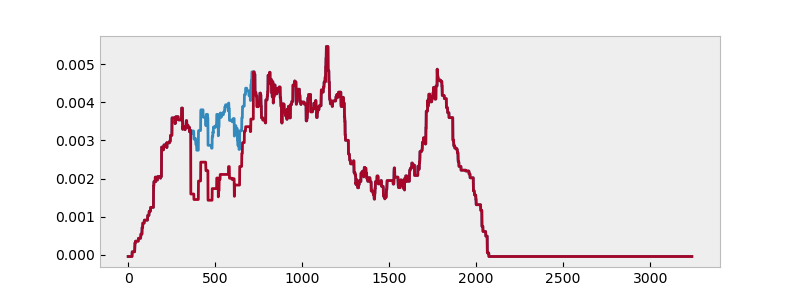

In [89]:
plt.figure(figsize=(8, 3))
plt.plot(img_bin_noise[19, 11, :])
plt.plot(img_bin_off[19, 11, :])

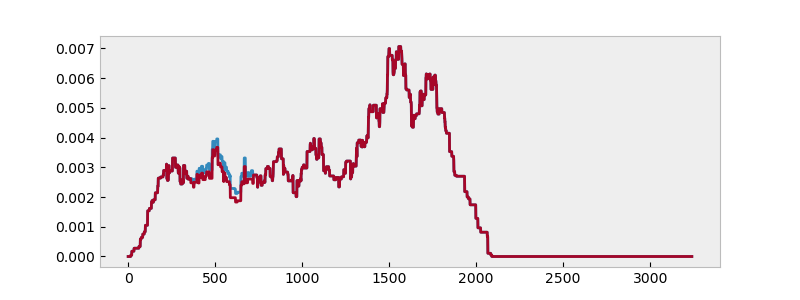

In [91]:
plt.figure(figsize=(8, 3))
plt.plot(img_bin_noise[20, 11, :])
plt.plot(img_bin_off[20, 11, :])

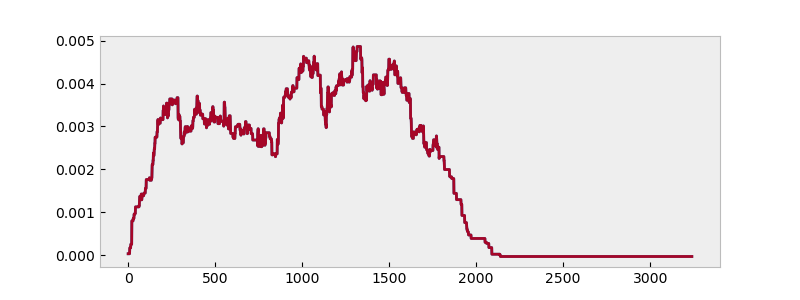

In [93]:
plt.figure(figsize=(8, 3))
plt.plot(img_bin_noise[21, 11, :])
plt.plot(img_bin_off[21, 11, :])

In [ ]:
"lets turn off a selected area and check the building's light curve"

In [100]:
# -- turn off all light sources in one building and check its light curve
# -- check the building ID
ID = np.unique(bimg[17*80:21*80, 10*80:11*80])
ID

array([1008310042, 1008320039, 1008320041, 1008320049, 1008330049,
       1008330051, 1008330052, 1008330054, 1008337502, 1008350041,
       1008460030, 1008460033, 1008470027, 1008470029, 1008470033,
       1008470040, 1008470050, 1008480023, 1008480028, 1008497501,
       1008507501, 1008510060, 1008517505, 1008560009, 1008567502,
       1008570076, 1008580001])

In [112]:
# -- get the building locations
ind = np.where(bimg == ID[0])
bldg_loc = np.array([ind[0],ind[1]]).T
bldg_loc.shape

(308, 2)

In [126]:
bldg_crv_raw = []
# -- get the light curve of this building
for i in range(len(bldg_loc)):
    bldg_crv_raw.append(imgs[bldg_loc[i][0], bldg_loc[i][1], :])

In [127]:
bldg_crv_raw = np.array(bldg_crv_raw)

In [99]:
# -- select the builing and turn off this building from 10 to 11 pm
for i in range(len(buid_loc)):
    imgs[17*80:21*80, 10*80:11*80, 360:720] = 0
    
# -- bin our image by 80 and get the time series image for a given night
fac = 80
sh = imgs.shape
img_bin_off_area = imgs.reshape(sh[0]//fac, fac, sh[1]//fac, fac, sh[2]).mean(axis=(1, 3))

# -- add noise to binned image
for i in range(3240):
    img_bin_off_area[:, :, i] = img_bin_off[:, :, i] + gaussian

In [113]:
bldg_crv = []
# -- get the light curve of this building
for i in range(len(bldg_loc)):
    bldg_crv.append(imgs[bldg_loc[i][0], bldg_loc[i][1], :])
    

In [114]:
bldg_crv = np.array(bldg_crv)

In [122]:
bldg_crv.shape

(308, 3240)

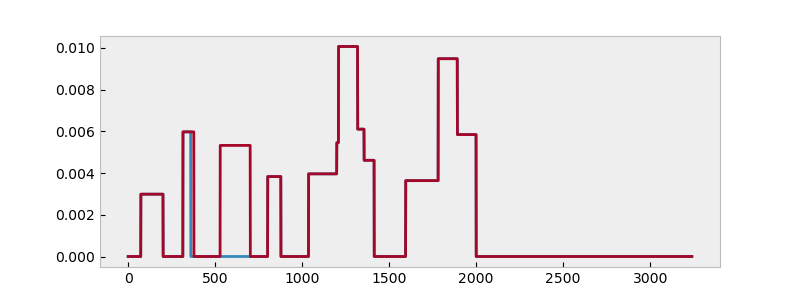

In [128]:
# building id 1008310042 light curve before power off and after
plt.figure(figsize=(8, 3))
plt.plot(bldg_crv.mean(axis=0))
plt.plot(bldg_crv_raw.mean(axis=0))

In [ ]:
30 time series, mean 